In [ ]:
from Functions import extractWeeklyData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pickle as pkl
###Feature Extraction
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.utilities.dataframe_functions import impute
###DATA SCALING
from sklearn.preprocessing import MinMaxScaler
###MODEL
from keras.models import load_model


In [ ]:
### Directory
mydir = "/Valve5/2020/10/26_16-02-39/"

In [ ]:
### select ID of valve
n = 5

In [ ]:
df5_test = extractWeeklyData(n)
print(df5_test.head())


In [ ]:
### data segmentation - rolled window
window_size = 60
df5_test_rolled = roll_time_series(df5_test, column_id="id", column_sort="date",column_kind=None, rolling_direction=1, max_timeshift=(window_size-1))

In [ ]:
### load minimal set of features
with open(mydir + "parameters.pkl", "rb") as infile:
        kind_to_fc_parameters = pkl.load(infile)

In [ ]:
### reduced feature extraction
df5_test_min = extract_features(df5_test_rolled, column_id='id', column_sort='date', n_jobs=0, kind_to_fc_parameters=kind_to_fc_parameters, impute_function=impute)

In [ ]:
#scaling
scaler = MinMaxScaler()
X_test = scaler.transform(df5_test_min)

In [ ]:
### reshape dat to 3D tensor
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
### load model
model = load_model(mydir + "model.h5")

In [ ]:
### load threshold
with open(mydir+ "threshold.pkl", "rb") as infile:
        threshold = pkl.load(infile)

In [ ]:
### calculate the loss on the test set
X_pred2 = model.predict(X_test)
X_pred2 = X_pred2.reshape(X_pred2.shape[0], X_pred2.shape[2])
X_pred2 = pd.DataFrame(X_pred2, columns=df5_test_min.columns)
X_pred2.index = df5_test_min.index

scored2 = pd.DataFrame(index=df5_test_min.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored2['Loss_mse'] =(np.square(X_pred2 - Xtest)).mean(axis=1)
scored2['Axis'] = range(len(scored2['Loss_mse']))
coefficients, residuals, _, _, _ = np.polyfit(scored2['Axis'],scored2['Loss_mse'], 1, full = True)
scored2['Trend'] = ([coefficients[0]*x + coefficients[1] for x in range(len(scored2['Loss_mse']))])
scored2.drop('Axis', 1, inplace=True)
scored2['Threshold'] = threshold
scored2['Anomaly'] = scored2['Trend'] > scored2['Threshold']


In [ ]:
### plot  failure time plot
scored2.plot(logy=True, color=['grey', 'black', 'red'])
plt.show()

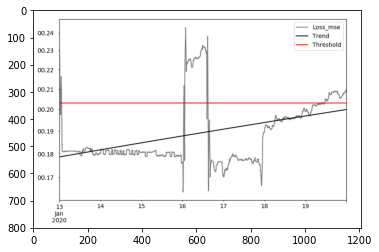

In [6]:
plt.imshow(img)